Images made up of a trillion pixels, known as terapixel images, can effectively present information to stakeholders, but they require a significant amount of computing power. To minimize costs and optimize the process, it is beneficial to use cloud supercomputing infrastructure to analyze the data collected during the production of a terapixel image of Newcastle Upon Tyne. The problem addressed in this situation is how to deliver the necessary supercomputer resources for the computation of this large-scale image. The goal is to examine the data from the application checkpoint and system metric output, in order to improve the cost-efficiency of the process.

Business Understanding

The purpose of this analysis is to assist users who wish to process large terapixel images on a cloud platform. It focuses on two main goals: reducing costs and enhancing the performance of image rendering. By utilizing cloud resources for heavy computation, costs can be reduced as there is no need for a significant initial investment in hardware. However, it is important to properly manage resources to keep costs from getting too high. The performance of image rendering will be analyzed by examining various factors such as power consumption, GPU utilization, memory usage, and more.



Data Understanding

The dataset highlighted here was generated from a run utilizing 1024 graphics processing units. This operation was divided into three tasks, specifically levels 4, 8, and 12 of the visualization output. The information supplied illustrates the timing of the render application's performance, the performance of the GPU, and specifics on the portion of the image that was being processed in each job.

The Three files are:
application-checkpoints.csv 
gpu.csv 
task-x-y.csv

application-checkpoints.csv
This file contains 6 features which are:
timestamp
hostname :hostname of the virtual machine auto-assigned by the Azure batch system.
eventName:Name of the event occuring within the rendering application.
    The possible values are:
        TotalRender is the entire task
        Render is when the image tile is is being rendered
        Saving Config is simply a measure of configuration overhead
        Tiling is where post processing of the rendered tile is taking place
        Uploading is where the output from post processing is uploaded to Azure Blob Storage
        
eventType
    The possible Values are:
        "START"
        "STOP"
jobId :ID of the Azure batch job
taskId: ID of the Azure batch task.


gpu.csv 
This file contains metrics that were output regarding the status of the GPU on the virtual machine.This also contains 6 features which are:
timestamp
hostname : hostname of the virtual machine auto-assigned by the Azure batch system.
gpuSerial: The serial number of the physical GPU card.
gpuUUID: The unique system id assigned by the Azure system to the GPU unit.
powerDrawWatt: Power draw of the GPU in watts.
gpuTempC: Temperature of the GPU in Celsius
gpuUtilPerc: Percent utilisation of the GPU Core(s).
gpuMemUtilPerc: Percent utilisation of the GPU memory.

task-x-y.csv
This file contains the x,y co-ordinates of which part the image was being rendered for each task.This contains 5 features which are:

jobId :ID of the Azure batch job
taskId: ID of the Azure batch task.
x: X co-ordinate of the image tile being rendered.
y: Y co-ordinate of the image tile being rendered.
level: The visualisation created is a zoomable "google maps style" map. In total we create 12 levels. Level 1 is zoomed right out and level 12 is zoomed right in. You will only see levels 4, 8 and 12 in the data as the intermediate level are derived in the tiling process.








Data Processing



In [5]:
import pandas as pd
# from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib import pyplot
from pandas import Series
import statistics

from datetime import datetime as dt, date
from dateutil import parser

In [2]:
app_check = pd.read_csv("application-checkpoints.csv")
gpu = pd.read_csv("gpu.csv")
taskxy = pd.read_csv("task-x-y.csv")

In [3]:
app_taskxy = pd.merge(taskxy, app_check, on = ['jobId', 'taskId'], how='left')
app_taskxy_gpu = pd.merge(app_taskxy, gpu, on=['timestamp'])


In [6]:
app_taskxy_gpu = app_taskxy_gpu.loc[:,~app_taskxy_gpu.columns.duplicated()] # deleting duplicate rows...
app_taskxy_gpu["time"] = app_taskxy_gpu["timestamp"].apply(lambda x: parser.isoparse(x))

In [7]:
app_taskxy_gpu.head()

,taskId,jobId,x,y,level,timestamp,hostname_x,eventName,eventType,hostname_y,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,time
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,265232c5f6814768aeefa66a7bec6ff600000Q,323617020812,GPU-f8ed40fb-e2c2-d6e2-9a66-4b6eaae14912,125.89,39,92,60,2018-11-08 08:07:10.688000+00:00
1,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,0d56a730076643d585f77e00d2d8521a00000Q,325117171574,GPU-d84a1024-9381-c725-3b85-dd7143e64c35,25.91,33,0,0,2018-11-08 08:07:10.688000+00:00
2,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,START,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
3,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Render,STOP,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
4,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:49.863Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,TotalRender,STOP,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00


What is the interplay between GPU temperature and performance?


In [21]:
start_df = app_taskxy_gpu[app_taskxy_gpu['eventType'] == 'START']
stop_df = app_taskxy_gpu[app_taskxy_gpu['eventType'] == 'STOP']
start_df.rename(
        index=str, columns={"time": "start_time"}, inplace = True)
stop_df.rename(
        index=str, columns={"time": "stop_time"}, inplace = True)

stop_df.drop('eventType', axis = 1, inplace = True)
start_df.drop('eventType', axis = 1, inplace = True)
   
# # Make each field record start and stop combined
   
df = pd.merge( start_df, stop_df, 
            on=['eventName', 'x', 'y', 'level'])


# # Finding the duration
df['duration'] = (df['stop_time'] - df['start_time']).dt.total_seconds()
df


C:\Users\Ashu\AppData\Local\Temp\ipykernel_11600\2949399360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df.rename(
C:\Users\Ashu\AppData\Local\Temp\ipykernel_11600\2949399360.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_df.rename(
C:\Users\Ashu\AppData\Local\Temp\ipykernel_11600\2949399360.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_df.drop('eventType', axis = 1, inplace = True)
C:\Users\Ashu\AppD

,taskId_x,jobId_x,x,y,level,timestamp_x,hostname_x_x,eventName,hostname_y_x,gpuSerial_x,...,hostname_x_y,hostname_y_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,stop_time,duration
0,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,d8241877cd994572b46c861e5d144c8500000W,323617021323,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00,1.008
1,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,0745914f4de046078517041d70b22fe7000014,325117064385,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,8b6a0eebc87b4cb2b0539e81075191b900000T,323617021011,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
3,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,265232c5f6814768aeefa66a7bec6ff600000T,323617020801,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
4,000d1def-1478-40d3-a5e3-4f848daee474,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,179,226,12,2018-11-08T08:21:27.481Z,b9a1fa7ae2f74eb68f25f607980f97d700000V,Tiling,b9a1fa7ae2f74eb68f25f607980f97d7000019,324917052134,...,b9a1fa7ae2f74eb68f25f607980f97d700000V,4ad946d4435c42dabb5073531ea4f315000018,325017018095,GPU-6ab2031f-938b-3d9a-fc14-9c9e308d2716,118.93,40,91,46,2018-11-08 08:21:28.583000+00:00,1.102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86628,ecb08d02-79b5-43ef-b58c-b55b4b84e39c,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,12,4,8,2018-11-08T07:42:39.161Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,Uploading,8b6a0eebc87b4cb2b0539e81075191b900001D,323617021151,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,265232c5f6814768aeefa66a7bec6ff6000010,323617020951,GPU-af3d11cb-8a8c-1d21-2906-216f0a3e55ad,34.37,34,1,0,2018-11-08 07:42:40.187000+00:00,1.026
86629,f7b53cc0-d2f1-421b-a7a1-4949ddc38075,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,2,6,8,2018-11-08T07:42:50.906Z,cd44f5819eba427a816e7ce648adceb2000001,Uploading,265232c5f6814768aeefa66a7bec6ff6000001,323217056104,...,cd44f5819eba427a816e7ce648adceb2000001,a77ef58b13ad4c01b769dac8409af3f800000X,323617020586,GPU-9c0266e2-aa48-361b-455e-f5fc6159ee31,83.40,35,82,34,2018-11-08 07:42:51.970000+00:00,1.064
86630,f8559617-7298-4ee0-9742-9e9e7b5f54df,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,14,3,8,2018-11-08T07:43:14.194Z,0d56a730076643d585f77e00d2d8521a00000R,Tiling,6139a35676de44d6b61ec247f0ed8657000018,325017018337,...,0d56a730076643d585f77e00d2d8521a00000R,83ea61ac1ef54f27a3bf7bd0f41ecaa700000X,323617043082,GPU-88356e9f-7159-3ed6-b131-c4bfc506e7e9,94.95,43,89,44,2018-11-08 07:43:15.317000+00:00,1.123
86631,fb9f46a2-a940-4773-996f-6db2204350d2,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,0,0,8,2018-11-08T07:42:13.045Z,04dc4e9647154250beeee51b866b071500000X,Uploading,04dc4e9647154250beeee51b866b071500000T,323217056004,...,04dc4e9647154250beeee51b866b071500000X,b9a1fa7ae2f74eb68f25f607980f97d700001A,325017017862,GPU-7788192a-b813-3215-3ac6-93f8991b577f,26.70,31,0,0,2018-11-08 07:42:34.016000+00:0

In [19]:
start_df.head()

,taskId,jobId,x,y,level,start_time,hostname_x,eventName,hostname_y,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,time
2,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
7,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:48:46.175Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,TotalRender,dcc19f48bb3445a28338db3a8f002e9c00001C,323617043038,GPU-107fdc0f-36d3-62e5-58e5-b11527010f1c,70.38,44,89,53,2018-11-08 07:48:46.175000+00:00
8,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:48:46.175Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Saving Config,dcc19f48bb3445a28338db3a8f002e9c00001C,323617043038,GPU-107fdc0f-36d3-62e5-58e5-b11527010f1c,70.38,44,89,53,2018-11-08 07:48:46.175000+00:00
11,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,0745914f4de046078517041d70b22fe7000014,325117064385,GPU-3ba7819f-90bf-f33c-cabe-3b1e83d80ca8,48.17,42,0,0,2018-11-08 07:49:17.082000+00:00
12,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,8b6a0eebc87b4cb2b0539e81075191b900000T,323617021011,GPU-d93f9cba-097b-3d79-ffea-37e5c10748af,126.39,41,94,51,2018-11-08 07:49:17.082000+00:00


Which event types dominate task runtimes?

To evaluate which events are dominating the runtime, some preprocessing is required.
From the app_taskxy_gpu file, the eventName is filtered by start time and stop time and a new collumn is created as duration which contains the difference of start time and stop time in seconds.

A boxplot for all five events displays the range, Meadian of duration among which the event is running.




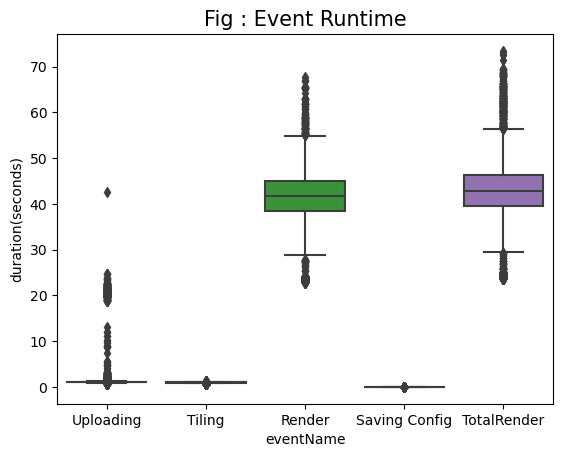

In [29]:
# Creating a boxplot
sns.boxplot(x="eventName", y="duration", data=df)
plt.xlabel('eventName', fontsize = 10)
plt.ylabel('duration(seconds)', fontsize = 10)
plt.title("Fig1 : Event Runtime", fontsize = 15)
plt.show()

From the above figure we infer that the Events Render and TotalRender has the highest processing time and hence these are the events which are dominating the task runtimes.

The Average runtime of the event Render and TotalRender is approximately 43 seconds.

The events Uploading, Render and TotalRender has significant number of outliers hence there could be a high bias on the average runtime of these events.

Also the rest three events Uploading, Tiling and Saving Config does not take much time to run.




What is the interplay between GPU temperature and performance?

To evaluate this we plot a graph between PowerDraw and GPU Temperature , PowerDraw and GPU Memory Utility, 
GPU Memory Utility and GPU Utility.

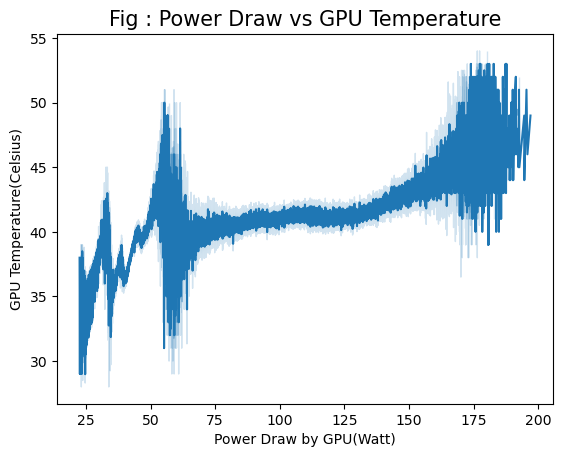

In [11]:
ax = sns.lineplot(data=gpu, x="powerDrawWatt", y="gpuTempC")
plt.xlabel('Power Draw by GPU(Watt)', fontsize = 10)
plt.ylabel('GPU Temperature(Celsius)', fontsize = 10)
plt.title("Fig 2 : Power Draw vs GPU Temperature", fontsize = 15)
plt.show()

From the above figure we infer that with increase in Power Draw there is gradual increase in gpu temperature. While the Power Draw ranges from 25W to 200 w, the gpu temperature ranges from 25 celsius to 55 celsius.

Also we have two major spikes in the line graph around 60W and 180W. The first spike dignifies that some GPU's fail to give optimal performance at lower temperatures while the later shows that there are a few strong GPU's which are still able to give optimal performance at very high temperatures.

Hence we can say that a lot of GPU's are equipped with good cooling infrastructure and therefore are able to provide high performance even after reaching high tempratures.

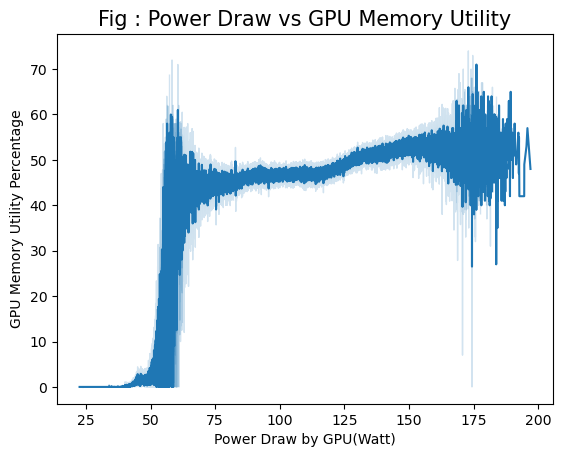

In [30]:
ax = sns.lineplot(data=gpu, x="powerDrawWatt", y="gpuMemUtilPerc")
plt.xlabel('Power Draw by GPU(Watt)', fontsize = 10)
plt.ylabel('GPU Memory Utility Percentage', fontsize = 10)
plt.title("Fig 3: Power Draw vs GPU Memory Utility", fontsize = 15)
plt.show()

Even in this plot we find similar trends. With an increase in Power Draw(performance), more gpu memory is being utilised and vice a versa. 
Even in this plot we can see that a few GPU's are at peak Memory utilisation at 60W indicating a low performing GPU. But here we can see that after around 160W there is also some drop in performance. This can be attributed to GPU throttling.

In [35]:
avg_data = app_taskxy_gpu[app_taskxy_gpu['eventName'] != 'TotalRender'][['gpuSerial', 'eventName', 'gpuTempC', 'gpuUtilPerc', 'gpuMemUtilPerc', 'powerDrawWatt']].groupby(['gpuSerial','eventName']).mean()
avg_data.index.names = ['gpuSerial', 'eventName']
avg_data.reset_index(inplace=True)

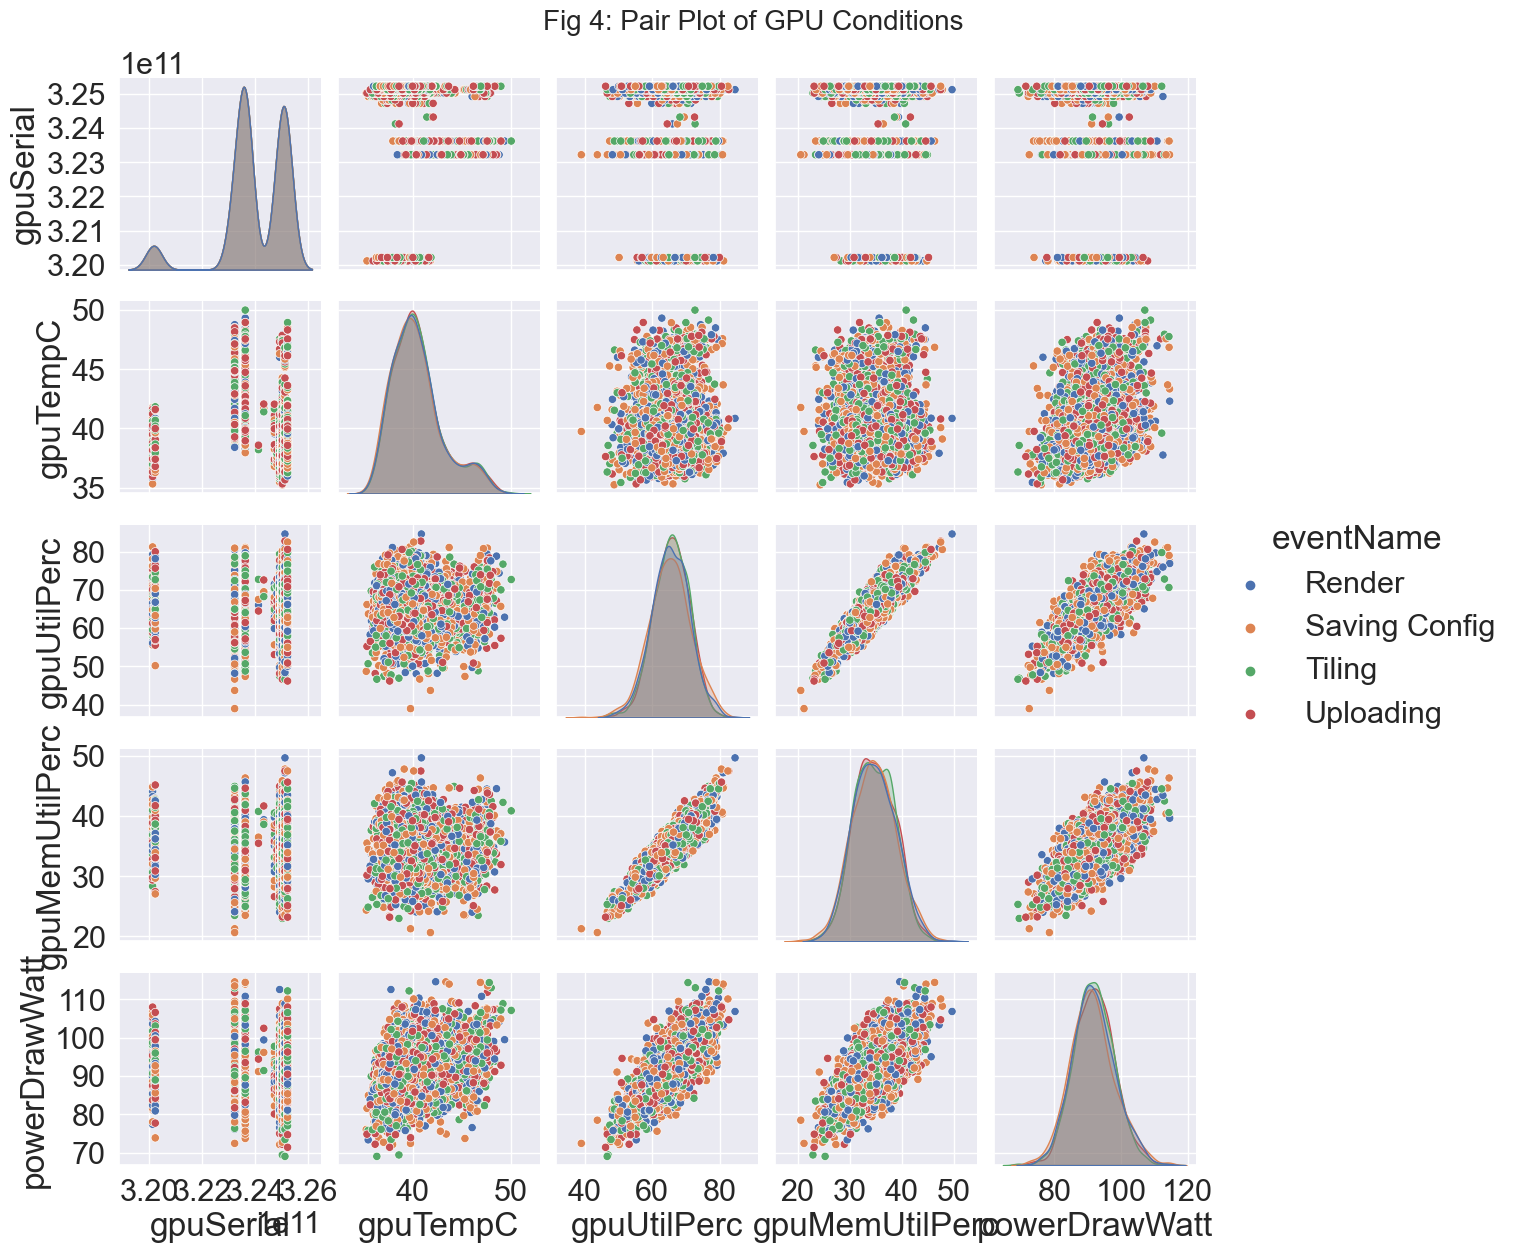

In [39]:
pp = sns.pairplot(avg_data, hue="eventName")
sns.set(font_scale = 1) # settng text font scale...
pp.fig.suptitle("Fig 4: Pair Plot of GPU Conditions", fontsize = 20, y=1.01)
plt.show()


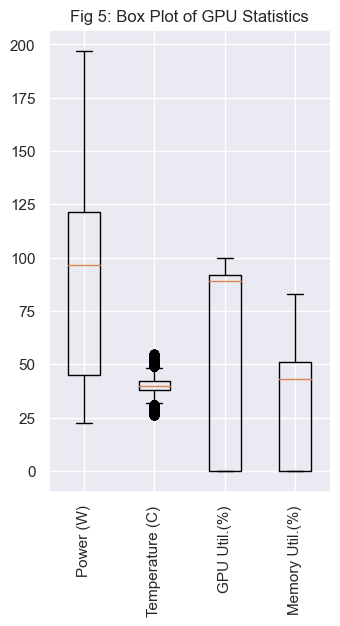

In [54]:
#Analyzing GPU Hardware performance visually
gpu_stats = ['Power (W)','Temperature (C)','GPU Util.(%)','Memory Util.(%)']

plt.subplot(1, 2, 1)
plt.boxplot([gpu['powerDrawWatt'], gpu['gpuTempC'],
gpu['gpuUtilPerc'], gpu['gpuMemUtilPerc']])

# Add labels
plt.xticks([i+1 for i, x in enumerate(gpu_stats)],
gpu_stats, rotation='vertical')

# Plot Title
plt.title('Fig 5: Box Plot of GPU Statistics')
plt.rcParams['figure.figsize'] = [6, 6]

# Saving Image
# plt.savefig('Images/Box-plot.png')
plt.show()

The average power consumption is approximately 95W.
The average Temperature is 35 degree celsius.
The average GPU utilization is 80%.
The average Memory Utilization is 40%.

From this we infer that we have almost equal number of low performing and high performing GPU's since on the GPU's are able to consistently provide average performance at high GPU utilization.